In [1]:
import matplotlib.pyplot as plt

In [2]:
import cartopy.crs as ccrs

In [3]:
import xarray as xr

In [4]:
import cartopy

In [5]:
import numpy as np

In [6]:
import cf_xarray as cf

In [29]:
cd /g/data/tm70/as2285/om3-utils/

/g/data/tm70/as2285/om3-utils


In [27]:
ls

data_stream_xml_generation/  LICENSE           README.md
grid_generation/             mesh_generation/


In [28]:
ll

total 28
drwxrwSr-x 2 as2285  4096 Feb 26 16:08 data_stream_xml_generation/
drwxrwSr-x 9 as2285  4096 Mar 28 15:58 grid_generation/
-rw-rw-r-- 1 as2285 11357 Feb 26 16:04 LICENSE
drwxrwSr-x 2 as2285  4096 Feb 26 16:04 mesh_generation/
-rw-rw-r-- 1 as2285  1417 Feb 26 16:04 README.md


Make a 8 deg global tripolar grid in the mom supergrid format

In [10]:
cd tests

/g/data/tm70/as2285/om3-utils/tests


In [11]:
from ocean_model_grid_generator.ocean_grid_generator import main as ocean_grid_generator

In [12]:
ocean_grid_generator(**{
        'inverse_resolution': 0.25 , #4 degree grid
        'no_south_cap': True,
        'ensure_nj_even': True,
        'match_dy': ["bp", "so", "p125sc", ""]
    })

Requesting Mercator grid with phi range: phi_s,phi_n= -66.85954725 64.05895973
   y*= [-45  42] nj= 88
  *Supergrid has an odd number of area cells!
  *Fixing this by shifting the y_star[1] 
   Generating Mercator grid with phi range: phi_s,phi_n= [-66.51326044  63.1137544 ]
   Equator is at j= 45
   Final Mercator grid range= -66.51326044311185 63.11375440256549
   number of js= 87
   CHECK_metrics: % errors in (area, lat arc, lon arc) (0.0, 0.0, 0.0)
   Match dy at bipolar cap joint
Generating bipolar grid bounded at latitude  63.11375440256549
   Supergrid has an odd number of area cells!
   The number of j's is not even. Fixing this by cutting one row.
   number of js= 29
   Calculating bipolar cap metrics via quadrature ...
   CHECK_metrics_hquad: % errors in (area, lat arc, lon arc1, lon arc2) (1.0426141492315303e-10, 0.0, -2.0578906542161463e-14, 0.0)
   Match dy at Southern Ocean joint
Generating regular lat-lon grid between latitudes  -78.0 -66.51326044311185
   generated regu

/g/data/tm70/as2285/om3-utils/tests/ocean_model_grid_generator/ocean_grid_generator.py:47: RuntimeWarning: invalid value encountered in multiply
  rden = 1.0 / (1.0 + alpha2 * beta2_inv)
/g/data/tm70/as2285/om3-utils/tests/ocean_model_grid_generator/ocean_grid_generator.py:82: RuntimeWarning: invalid value encountered in multiply
  cos2phis * alpha2 * (1 - alpha2) * beta2_inv * (1 + beta2_inv) * (rden ** 2)
/g/data/tm70/as2285/om3-utils/tests/ocean_model_grid_generator/ocean_grid_generator.py:90: RuntimeWarning: invalid value encountered in multiply
  cos2phis * (1 + beta2_inv) * (rden ** 2)
/g/data/tm70/as2285/om3-utils/tests/ocean_model_grid_generator/ocean_grid_generator.py:91: RuntimeWarning: invalid value encountered in multiply
  + M_inv * M_inv * alpha2 * beta2_inv * rden


In [30]:
mom_grid = xr.open_dataset('ocean_hgrid.nc')

In [31]:
mom_grid

<xarray.Dataset> Size: 1MB
Dimensions:   (nyp: 129, nxp: 181, ny: 128, nx: 180)
Dimensions without coordinates: nyp, nxp, ny, nx
Data variables:
    tile      |S255 255B ...
    y         (nyp, nxp) float64 187kB ...
    x         (nyp, nxp) float64 187kB ...
    dy        (ny, nxp) float64 185kB ...
    dx        (nyp, nx) float64 186kB ...
    area      (ny, nx) float64 184kB ...
    angle_dx  (nyp, nxp) float64 187kB ...
Attributes:
    history:      This grid file was generated via command /g/data/hh5/public...
    description:  This is an orthogonal coordinate grid for the Earth with a ...
    source:       /g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/bin...

In [32]:
mom_grid['x'].attrs['units']

'degrees'

In [33]:
cf_attributes = {
        'ulat': {'standard_name':'latitude', 'units':'radians', 'grid_mapping': 'crs'},
        'ulon': {'standard_name':'longitude', 'units':'radians', 'grid_mapping': 'crs'},
        'tlat': {'standard_name':'latitude', 'units':'radians', 'grid_mapping': 'crs'},
        'tlon': {'standard_name':'longitude', 'units':'radians', 'grid_mapping': 'crs'},
        'uarea': {'standard_name':'cell_area', 'units':'m^2', 'grid_mapping': 'crs'},
        'tarea': {'standard_name':'cell_area', 'units':'m^2', 'grid_mapping': 'crs'},
    }

In [34]:
cf_attributes['ulat']['standard_name']

'latitude'

In [35]:
mom_grid.x.max()

<xarray.DataArray 'x' ()> Size: 8B
array(60.)

An ocean mask with no masking

In [36]:
ocean_mask = xr.Dataset()

ocean_mask['mask']=((mom_grid.area.coarsen(ny=2).sum().coarsen(nx=2).sum())>=5e9)

ocean_mask.to_netcdf('ocean_mask.nc')

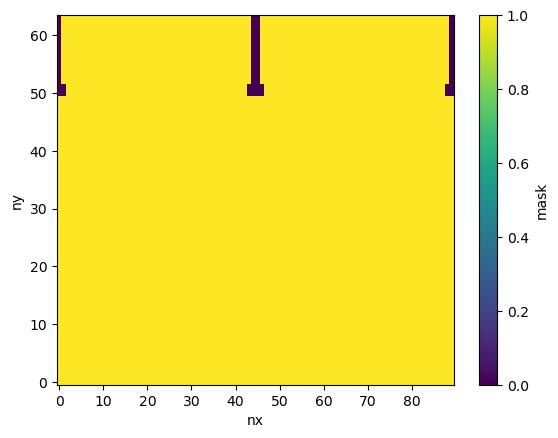

In [37]:
ocean_mask.mask.plot()

Looks like a grid

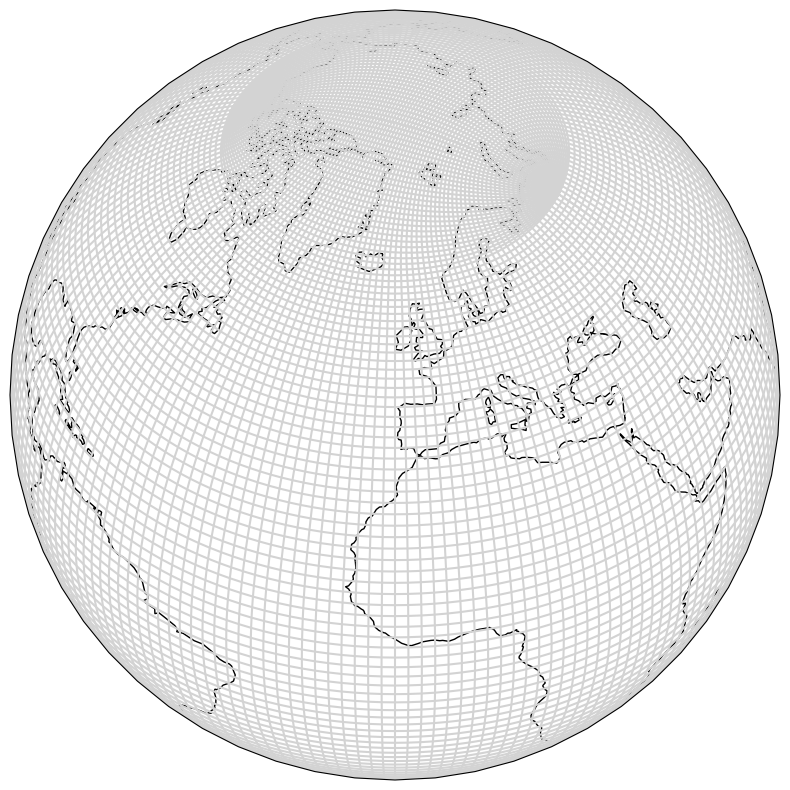

In [22]:
crs = ccrs.Orthographic(-10, 45)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=crs)

ax.set_global()
# ax.gridlines()
ax.coastlines()

_ = plt.plot(mom_grid.x, mom_grid.y, transform=ccrs.PlateCarree(), color='lightgrey')
_ = plt.plot(mom_grid.x.transpose(), mom_grid.y.transpose(), transform=ccrs.PlateCarree(),color='lightgrey')

### Make the cice grid

In [38]:
rm 'grid.nc' 'kmt.nc'

In [42]:
cd /g/data/tm70/as2285/om3-scripts/grid_generation/

/g/data/tm70/as2285/om3-scripts/grid_generation


In [43]:
! python3 make_cice_grid.py ocean_hgrid.nc ocean_mask.nc

In [50]:
cice_grid = xr.open_dataset('grid.nc', decode_cf=False)

In [51]:
cice_grid

<xarray.Dataset> Size: 8MB
Dimensions:  (ny: 262, nx: 360)
Dimensions without coordinates: ny, nx
Data variables:
    ulat     (ny, nx) float64 755kB ...
    ulon     (ny, nx) float64 755kB ...
    tlat     (ny, nx) float64 755kB ...
    tlon     (ny, nx) float64 755kB ...
    htn      (ny, nx) float64 755kB ...
    hte      (ny, nx) float64 755kB ...
    angle    (ny, nx) float64 755kB ...
    angleT   (ny, nx) float64 755kB ...
    tarea    (ny, nx) float64 755kB ...
    uarea    (ny, nx) float64 755kB ...
    crs      |S1 1B ...
Attributes:
    timeGenerated:    2024-04-02 16:31:14.742894
    created_by:       as2285
    history:          Created using commit bbc2a563d06dc7b4eb3c6e6d0fd7d3f5a9...
    inputfile:        ocean_hgrid.nc
    inputfile_md5:    99a1566dd4e5c9c126b536dfbda09b34
    history_command:  python make_CICE_grid.py ocean_hgrid.nc ocean_mask.nc
    Conventions:      CF-1.6

In [49]:
cice_grid.cf

Coordinates:
             CF Axes:   X, Y, Z, T: n/a

      CF Coordinates:   longitude: ['tlon', 'ulon']
                        latitude: ['tlat', 'ulat']
                        vertical, time: n/a

       Cell Measures:   area, volume: n/a

      Standard Names:   latitude: ['tlat', 'ulat']
                        longitude: ['tlon', 'ulon']

              Bounds:   n/a

       Grid Mappings:   n/a

Data Variables:
       Cell Measures:   area, volume: n/a

      Standard Names:   angle_of_rotation_from_east_to_x: ['angle', 'angleT']
                        cell_area: ['tarea', 'uarea']

              Bounds:   n/a

       Grid Mappings:   tripolar_latitude_longitude: ['crs']

Visual inspection

In [ ]:
crs = ccrs.Orthographic(-10, 45)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=crs)

ax.set_global()
# ax.gridlines()
# ax.coastlines()

_ = plt.plot(mom_grid.x, mom_grid.y, transform=ccrs.PlateCarree(), color='lightgrey')
_ = plt.plot(mom_grid.x.transpose(), mom_grid.y.transpose(), transform=ccrs.PlateCarree(),color='lightgrey')

_ = plt.plot(np.rad2deg(cice_grid.tlon), np.rad2deg(cice_grid.tlat), transform=ccrs.PlateCarree(), c='b')
_ = plt.plot(np.rad2deg(cice_grid.tlon).transpose(), np.rad2deg(cice_grid.tlat).transpose(), transform=ccrs.PlateCarree(), c='b')

_ = plt.plot(np.rad2deg(cice_grid.ulon), np.rad2deg(cice_grid.ulat), transform=ccrs.PlateCarree(), c='g')
_ = plt.plot(np.rad2deg(cice_grid.ulon).transpose(), np.rad2deg(cice_grid.ulat).transpose(), transform=ccrs.PlateCarree(), c='g')

Make a test cice grid in different way:

In [ ]:
test_grid = xr.Dataset()



test_grid['ulat']=np.deg2rad(mom_grid.y.isel(nxp=slice(2,None,2), nyp=slice(2,None,2)))

test_grid['ulon']=np.deg2rad(mom_grid.x.isel(nxp=slice(2,None,2), nyp=slice(2,None,2)))

test_grid['tlat']=np.deg2rad(mom_grid.y.isel(nxp=slice(1,None,2), nyp=slice(1,None,2)))

test_grid['tlon']=np.deg2rad(mom_grid.x.isel(nxp=slice(1,None,2), nyp=slice(1,None,2)))

test_grid['tarea']=mom_grid.area.coarsen(ny=2).sum().coarsen(nx=2).sum()

test_grid['htn']=(mom_grid.dx.isel(nyp=slice(2,None,2)).coarsen(nx=2).sum()*100)

test_grid['hte']=mom_grid.dy.isel(nxp=slice(2,None,2)).coarsen(ny=2).sum()*100

test_grid['angle']=np.deg2rad(mom_grid.angle_dx.isel(nyp=slice(2,None,2), nxp=slice(2,None,2)))

test_grid['angleT']=np.deg2rad(mom_grid.angle_dx.isel(nyp=slice(1,None,2), nxp=slice(1,None,2)))

area_wrapped = mom_grid.area

area_wrapped = xr.concat([
    mom_grid.area.isel(nx=slice(1,None)),
    mom_grid.area.isel(nx=0)
], dim='nx')

top_row = xr.concat([
    mom_grid.area.isel(ny=-1, nx=slice(-2,0,-1)),
    mom_grid.area.isel(ny=-1, nx=[-1,0])
], dim='nx')

area_folded = xr.concat([
    area_wrapped.isel(ny=slice(1,None)),
    top_row
], dim='ny')

test_grid['uarea'] = area_folded.coarsen(ny=2).sum().coarsen(nx=2).sum()

In [ ]:
my_set = set('hello')

In [ ]:
my_set == set()

In [ ]:
plt.figure(figsize=(25,80))



print("cice vars not in test?")
print(set(cice_grid.variables).difference(test_grid.variables))
print("missing test vars in cice?")
print(set(test_grid.variables).difference(cice_grid.variables))

for j,jVar in enumerate(set(cice_grid.variables).intersection(test_grid.variables)):
    
    plt.subplot(
        len(test_grid.variables),
        1,
        j+1
    )

    print(f'{jVar} allclose: {np.allclose(cice_grid[jVar],test_grid[jVar],rtol=1e-13)}')
            
    anom = (cice_grid[jVar].values-test_grid[jVar].values)

    print(f'{jVar} anom min: {anom.min()}, anom max: {anom.max()}')

    
    if (jVar in (['ulat','ulon','tlat','tlon', 'angle', 'angleT'])):
        anom = np.rad2deg(anom)        
        plt.pcolor(anom,vmin=-1, vmax=1, cmap='coolwarm')
    else:
        plt.pcolor(anom)

    plt.colorbar()
    plt.title(jVar)